In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.stats import ttest_ind
import statsmodels.api as sm

In [3]:
# Load the dataset
df = pd.read_csv('rhc.csv', index_col=0)

# Columns to exclude from the analysis
exclude_columns = ['sadmdte', 'lstctdte', 'dschdte']

# Exclude specified columns
df_sub = df.drop(columns=exclude_columns)

# Function to categorize columns into continuous, binary, and categorical
def categorize_columns(df):
    continuous_columns = []
    binary_columns = []
    categorical_columns = []
    
    for column in df.columns:
        unique_values = df[column].nunique()
        
        if unique_values == 2:
            binary_columns.append(column)
        elif unique_values > 2 and df[column].dtype == 'object':
            categorical_columns.append(column)
        else:
            continuous_columns.append(column)
            
    print(f"Number of continuous columns: {len(continuous_columns)}")
    print(f"Number of binary columns: {len(binary_columns)}")
    print(f"Number of categorical columns: {len(categorical_columns)}")
    
    return continuous_columns, binary_columns, categorical_columns

# Define outcome and treatment variables
Y = df_sub['death']
Z = df_sub['swang1']

# Remove outcome and treatment variables from the dataframe
df_confounders = df_sub.drop(columns=['death', 'swang1'])

# Categorize the confounder columns
continuous_columns, binary_columns, categorical_columns = categorize_columns(df_confounders)


Number of continuous columns: 26
Number of binary columns: 25
Number of categorical columns: 6


In [5]:
### Find how many possible classes for dummy variables
k = 0
for col in categorical_columns:
    k += df_sub[col].value_counts().__len__()
k

31

In [21]:
def encode_binary_columns(df, binary_columns):
    df_binary_encoded = df[binary_columns].copy()
    for column in binary_columns:
        unique_values = df_binary_encoded[column].unique()
        mapping = {unique_values[0]: 0, unique_values[1]: 1}
        df_binary_encoded[column] = df_binary_encoded[column].map(mapping)
    return df_binary_encoded

# Function to create dummy variables for categorical columns
def encode_categorical_columns(df, categorical_columns):
    df_categorical_encoded = pd.get_dummies(df[categorical_columns], drop_first=True, dummy_na=True)
    return df_categorical_encoded

# Encode binary columns including treatment variable Z
binary_columns_encoded = encode_binary_columns(df_sub, binary_columns + ['swang1', 'death'])

# Encode categorical columns
categorical_columns_encoded = encode_categorical_columns(df_sub, categorical_columns)

# Combine all the preprocessed columns
df_encoded = pd.concat([df_sub[continuous_columns], binary_columns_encoded, categorical_columns_encoded], axis=1)


In [13]:
## impute missing values
from sklearn.impute import SimpleImputer

df_continuous = df_encoded[continuous_columns]

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to our data
df_continuous_imputed = pd.DataFrame(imputer.fit_transform(df_continuous), columns=df_continuous.columns)
df_continuous_imputed.index.name = 'X'


In [14]:
df_binary = df_encoded[binary_columns]
def binary_encode(df, column):
    unique_values = df[column].dropna().unique()
    if len(unique_values) == 2:
        df[column] = df[column].map({unique_values[0]: 0, unique_values[1]: 1})
    return df

# Applying the binary_encode function to each binary column
df_binary_encoded = df_binary.copy()
for col in df_binary.columns:
    df_binary_encoded = binary_encode(df_binary_encoded, col)

In [27]:
df_categorical_dummies = categorical_columns_encoded

In [30]:
df_confounders_original = pd.concat([df_continuous_imputed, df_binary, df_categorical_dummies], axis=1)
log_reg_original = LogisticRegression(max_iter=1000)
log_reg_original.fit(df_confounders_original, Z)

# Getting the propensity scores
propensity_scores_original = log_reg_original.predict_proba(df_confounders_original)[:, 1]


/home/yurui/anaconda3/envs/drug_response_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
propensity_scores_original

array([0.55128811, 0.31104089, 0.36949355, ..., 0.22179982, 0.47641322,
       0.56459837])

In [32]:
df_continuous_imputed.reset_index(drop=True, inplace=True)
df_binary.reset_index(drop=True, inplace=True)
df_categorical_dummies.reset_index(drop=True, inplace=True)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# Applying PolynomialFeatures to the binary-encoded DataFrame and updating column names
df_binary_poly = pd.DataFrame(poly.fit_transform(df_binary_encoded))
binary_feature_names = poly.get_feature_names_out(input_features=df_binary_encoded.columns)
df_binary_poly.columns = binary_feature_names

# Applying PolynomialFeatures to the categorical dummies DataFrame and updating column names
df_categorical_dummies_poly = pd.DataFrame(poly.fit_transform(df_categorical_dummies))
categorical_feature_names = poly.get_feature_names_out(input_features=df_categorical_dummies.columns)
df_categorical_dummies_poly.columns = categorical_feature_names
# 3. Standardization/Scaling
scaler = StandardScaler()
df_binary_poly_scaled = pd.DataFrame(scaler.fit_transform(df_binary_poly), columns=df_binary_poly.columns)
df_categorical_dummies_poly_scaled = pd.DataFrame(scaler.fit_transform(df_categorical_dummies_poly), columns=df_categorical_dummies_poly.columns)
df_continuous_imputed_scaled = pd.DataFrame(scaler.fit_transform(df_continuous_imputed), columns=df_continuous_imputed.columns)

# Concatenating the dataframes
df_confounders_all = pd.concat([df_continuous_imputed_scaled, df_binary_poly_scaled, df_categorical_dummies_poly_scaled], axis=1)


In [33]:

# # Concatenating the dataframes
# df_confounders_all = pd.concat([df_continuous_imputed, df_binary, df_categorical_dummies], axis=1)

# Define the treatment variable Z

Z = df_sub['swang1']  # Assuming 'swang1' indicates whether RHC was received within 24 hours of admission
Z_bin = Z.replace({'RHC': 1, 'No RHC': 0})
X = df_confounders_all
y = Z_bin

# Create a logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Fit the model
log_reg.fit(X, y)

# Get the propensity scores, which are the probabilities of receiving the treatment
propensity_scores = log_reg.predict_proba(X)[:, 1]

In [34]:
propensity_scores

array([0.23402694, 0.32017558, 0.43869505, ..., 0.10440527, 0.17731617,
       0.75517147])

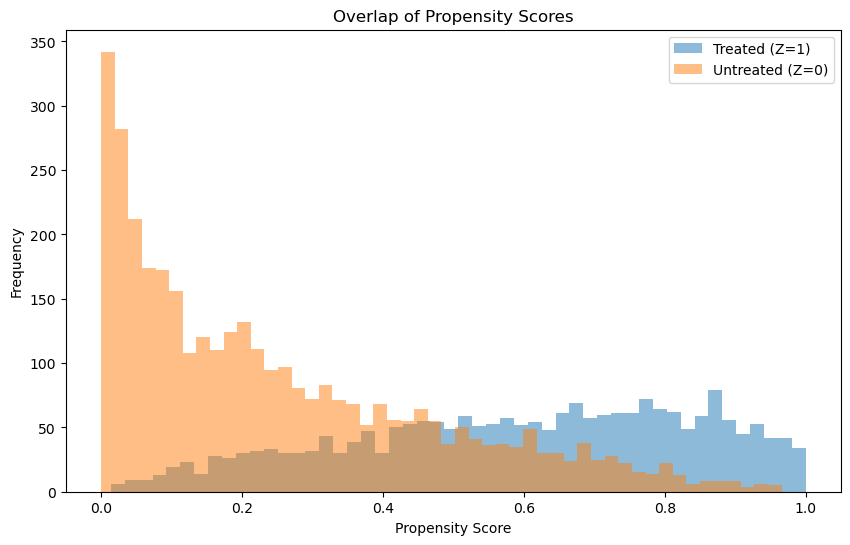

In [35]:
# Assuming `propensity_scores` and `Z_bin` are your propensity scores and treatment assignment
treated_scores = propensity_scores[Z_bin == 1]
untreated_scores = propensity_scores[Z_bin == 0]

plt.figure(figsize=(10, 6))
plt.hist(treated_scores, bins=50, alpha=0.5, label='Treated (Z=1)')
plt.hist(untreated_scores, bins=50, alpha=0.5, label='Untreated (Z=0)')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.title('Overlap of Propensity Scores')
plt.legend()
plt.show()


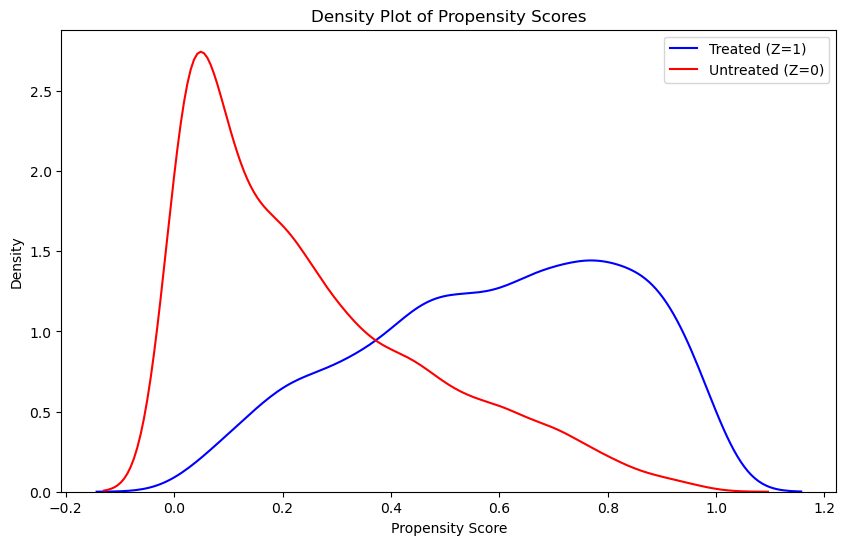

In [36]:
plt.figure(figsize=(10, 6))
sns.kdeplot(treated_scores, color='blue', label='Treated (Z=1)')
sns.kdeplot(untreated_scores, color='red', label='Untreated (Z=0)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Density Plot of Propensity Scores')
plt.legend()
plt.show()


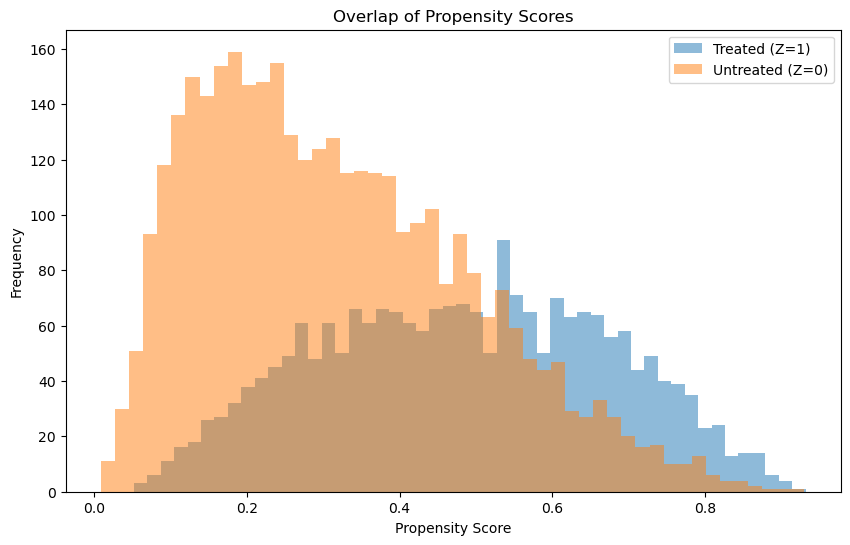

In [37]:
treated_scores = propensity_scores_original[Z_bin == 1]
untreated_scores = propensity_scores_original[Z_bin == 0]

plt.figure(figsize=(10, 6))
plt.hist(treated_scores, bins=50, alpha=0.5, label='Treated (Z=1)')
plt.hist(untreated_scores, bins=50, alpha=0.5, label='Untreated (Z=0)')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.title('Overlap of Propensity Scores')
plt.legend()
plt.show()

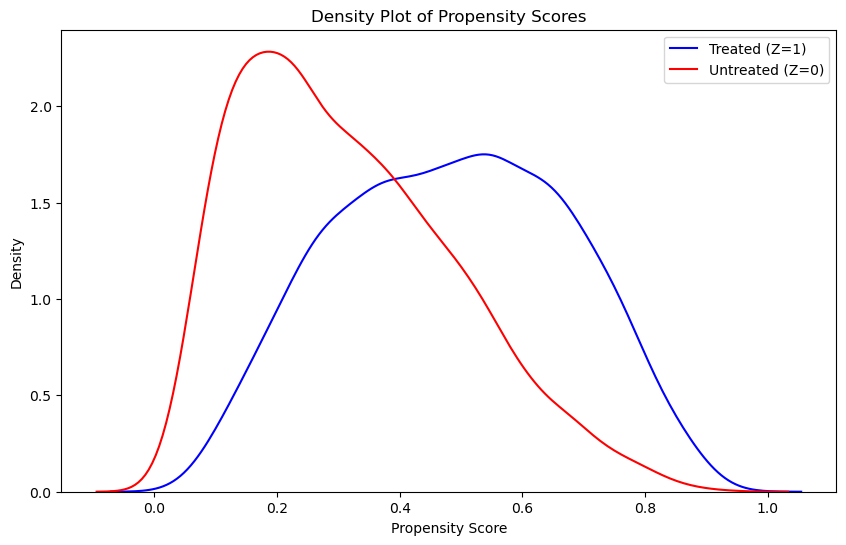

In [39]:
plt.figure(figsize=(10, 6))
sns.kdeplot(treated_scores, color='blue', label='Treated (Z=1)')
sns.kdeplot(untreated_scores, color='red', label='Untreated (Z=0)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Density Plot of Propensity Scores')
plt.legend()
plt.show()

In [38]:
Y = df_sub['death']  # Replace 'outcome' with the actual outcome column name

# Define the treatment variable Z
Z = df_sub['swang1'].replace({'RHC': 1, 'No RHC': 0})

# Define the covariates X (including the weighted covariates)
X = sm.add_constant(df_confounders_all)  # Adding a constant for the intercept
Z_reset = Z.reset_index(drop=True)
Y_reset = Y.reset_index(drop=True)
X_reset = X.reset_index(drop=True)

In [65]:
# Converting 'Yes' to 1 and 'No' to 0
Y_binary = Y_reset.replace({'Yes': 1, 'No': 0})

# Now, you can use Y_binary in your regression models
model_treated = sm.OLS(Y_binary[Z_reset == 1], X_reset[Z_reset == 1]).fit()
model_control = sm.OLS(Y_binary[Z_reset == 0], X_reset[Z_reset == 0]).fit()

# Predict the outcomes
Y1_pred = model_treated.predict(X_reset)
Y0_pred = model_control.predict(X_reset)

# Calculate the average predicted outcomes
E_Y1_given_X = Y1_pred.mean()
E_Y0_given_X = Y0_pred.mean()

print(f"E[Y(1)|X] = {E_Y1_given_X}")
print(f"E[Y(0)|X] = {E_Y0_given_X}")
# Calculate RD and RR
RD = E_Y1_given_X - E_Y0_given_X
RR = E_Y1_given_X / E_Y0_given_X

print(f"Risk Difference (RD): {RD}")
print(f"Risk Ratio (RR): {RR}")

E[Y(1)|X] = 0.6510757098059544
E[Y(0)|X] = 0.637931496419657
Risk Difference (RD): 0.013144213386297454
Risk Ratio (RR): 1.0206044276855248


In [66]:
# Assuming Z_reset contains your treatment variable Z
Z_indices_1 = Z_reset[Z_reset == 1].index
Z_indices_0 = Z_reset[Z_reset == 0].index

# Selecting propensity scores where Z is 1
propensity_scores_Z1 = propensity_scores[Z_indices_1]

# Selecting propensity scores where Z is 0
propensity_scores_Z0 = propensity_scores[Z_indices_0]
# For Z = 1
model_treated = sm.Logit(Y_binary.loc[Z_indices_1], sm.add_constant(propensity_scores[Z_indices_1])).fit()
# For Z = 0
model_control = sm.Logit(Y_binary.loc[Z_indices_0], sm.add_constant(propensity_scores[Z_indices_0])).fit()

# Get the predictions
Y1_pred = model_treated.predict(sm.add_constant(propensity_scores))
Y0_pred = model_control.predict(sm.add_constant(propensity_scores))

# Calculate the average predicted outcomes
E_Y1_given_eX = Y1_pred.mean()
E_Y0_given_eX = Y0_pred.mean()

print(f"E[Y(1)|e(X)] = {E_Y1_given_eX}")
print(f"E[Y(0)|e(X)] = {E_Y0_given_eX}")

# Calculate RD and RR
RD = E_Y1_given_eX - E_Y0_given_eX
RR = E_Y1_given_eX / E_Y0_given_eX

print(f"Risk Difference (RD): {RD}")
print(f"Risk Ratio (RR): {RR}")

Optimization terminated successfully.
         Current function value: 0.624261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658942
         Iterations 4
E[Y(1)|e(X)] = 0.6519228213123535
E[Y(0)|e(X)] = 0.6351228275721329
Risk Difference (RD): 0.016799993740220565
Risk Ratio (RR): 1.026451566548854


In [67]:
# IPW Weights
weights_ipw = np.where(Z_reset == 1, 1 / propensity_scores, 1 / (1 - propensity_scores))

# Fit a weighted regression model
model_ipw = sm.WLS(Y_binary, sm.add_constant(Z_reset), weights=weights_ipw).fit()

# Get the coefficients from the model which will give us the causal RD
RD_ipw_regression = model_ipw.params[1]

# Printing the RD
print(f"IPW Regression Risk Difference (RD): {RD_ipw_regression}")

# For RR, you might want to use a logistic regression model because the outcome is binary
model_ipw_logit = sm.Logit(Y_binary, sm.add_constant(Z_reset)).fit()
RR_ipw_regression = np.exp(model_ipw_logit.params[1])

# Printing the RR
print(f"IPW Regression Risk Ratio (RR): {RR_ipw_regression}")


IPW Regression Risk Difference (RD): 0.019162800454625692
Optimization terminated successfully.
         Current function value: 0.646726
         Iterations 4
IPW Regression Risk Ratio (RR): 1.2520375107001351


In [68]:
weights_ow = np.where(Z_reset == 1, 1 / propensity_scores, 1 / (1 - propensity_scores))

# Calculate the weighted means for treated and control groups
E_Y_given_Z1_ow = np.sum(weights_ow[Z_reset == 1] * Y_binary[Z_reset == 1]) / np.sum(weights_ow[Z_reset == 1])
E_Y_given_Z0_ow = np.sum(weights_ow[Z_reset == 0] * Y_binary[Z_reset == 0]) / np.sum(weights_ow[Z_reset == 0])

# Calculate RD and RR using overlap weights
RD_ow = E_Y_given_Z1_ow - E_Y_given_Z0_ow
RR_ow = E_Y_given_Z1_ow / E_Y_given_Z0_ow

print(f"Overlap Weights Risk Difference (RD): {RD_ow}")
print(f"Overlap Weights Risk Ratio (RR): {RR_ow}")


Overlap Weights Risk Difference (RD): 0.019162800454625595
Overlap Weights Risk Ratio (RR): 1.0297379250921708


In [69]:
weights_ow

array([1.30552894, 3.1232863 , 2.27948775, ..., 1.11657647, 1.2155338 ,
       4.08449128])